# Preface

In [1]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import ELBO, SVI

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 0.1

In [2]:
print("All models are wrong, but some are useful.")

All models are wrong, but some are useful.


### Code 0.2

In [3]:
x = jnp.arange(1, 3)
x = x * 10
x = jnp.log(x)
x = jnp.sum(x)
x = jnp.exp(x)
x

DeviceArray(200.00002, dtype=float32)

### Code 0.3

In [4]:
print(jnp.log(0.01 ** 200))
print(200 * jnp.log(0.01))

-inf
-921.03406


### Code 0.4

C:\Users\User\anaconda3\lib\site-packages\numpyro\infer\elbo.py:82: FutureWarning: Using ELBO directly in SVI is deprecated. Please use Trace_ELBO class instead.
  warnings.warn("Using ELBO directly in SVI is deprecated. Please use Trace_ELBO class instead.",


{'a': DeviceArray(-17.5791, dtype=float32), 'b': DeviceArray(3.932409, dtype=float32)}


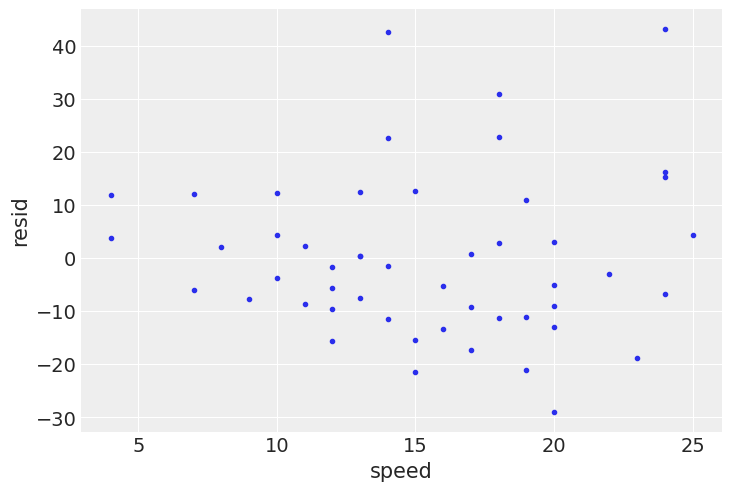

In [5]:
# Load the data:
# car braking distances in feet paired with speeds in km/h
# see cars.info() for details
cars = pd.read_csv("../data/cars.csv", index_col=0)

# fit a linear regression of distance on speed
def model(speed, dist_):
    mu = numpyro.param("a", 0.0) + numpyro.param("b", 1.0) * speed
    numpyro.sample("dist", dist.Normal(mu, 1), obs=dist_)


svi = SVI(
    model,
    lambda speed, dist_: None,
    optim=optim.Adam(1),
    loss=ELBO(),
    speed=cars.speed.values,
    dist_=cars.dist.values,
)
init_state = svi.init(random.PRNGKey(0))
state = lax.fori_loop(0, 1000, lambda i, x: svi.update(x)[0], init_state)
params = svi.get_params(state)

# estimated coefficients from the model
print(params)

# plot residuals against speed
resid = cars.dist - (params["a"] + params["b"] * cars.speed.values)
az.plot_pair({"speed": cars.speed, "resid": resid})
plt.show()

### Code 0.5

```sh
pip install numpyro arviz causalgraphicalmodels daft
```